# Vicsek and Boltzmann: A combo to model two dimensional dry active fluids

S.A.T. van Kraaij (s.a.t.v.kraaij@student.tue.nl)

April 2022, Eindhoven

[small abstract here]

---



In [47]:
%reset
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint
import random
import time
from itertools import product

""" Free Parameters and Physical Parameters """
Nx = 32 # Nodes of inner domain x-direction.
Ny = 128 # Nodes of inner domain in y-direction.
time_steps = 100 #1000 # Number of timesteps.

L = Ny # Wavelength of the initial perturbation
tau = 1 # Relaxation time
cs = np.sqrt(1/3) # Speed of sound
cs2 = cs**2
u0 = 0.2 # Characterstic velocity

""" Constants and Lattice-Boltzmann Parameters """
dt = 1 # Timestep
Q = 9 # Number of neighbouring nodes
weights = np.array([4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36])
C_matrix = np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]])
t_dump = 1 # Save data once any t_dump steps.
number_of_dumps = int(time_steps/t_dump)

""" Contact inhibition of locomotion """
A = 0.99 # A corresponds to the level of density-induced slowing down
B = 1
ux_star = np.zeros((Nx+2, Ny+2))
uy_star = np.zeros((Nx+2, Ny+2))
U0 = np.zeros((Nx+2, Ny+2))
eta = 1e-6 # Noise factor
sigma = 1 # Domain of random kicks

In [48]:
def set_periodic_bc(data):
    """
    Calculate the boundary conditions.
    """
    data[:,:,Ny+1] = data[:,:,1]
    data[:,:,0] = data[:,:,-2]
    data[:,0,:] = data[:,-2,:]
    data[:,Nx+1,:] = data[:,1,:]
    
    return data

def equilibrate(rho, ux, uy):
    """
    Calculates the equilibrium distribution.
    
    Params: rho (float), velocity (2D Array), q_index (int), weights (1D Array), C_matrix (2D Array)
    Return: 
    """
    data = np.zeros((Q,Nx+2,Ny+2))
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        velocity_in_C_i = C_matrix[k,0]*ux[i,j] + C_matrix[k,1]*uy[i,j]
        velocity_squared = ux[i,j]*ux[i,j]+uy[i,j]*uy[i,j]
        data[k,i,j] = weights[k]*rho[i,j]*(1+(velocity_in_C_i)/(cs**2) + (velocity_in_C_i**2)/(2*cs**4) - velocity_squared/(2*cs**2))
    return data

def calculate_steady_state(rho,ux,uy):
    """
    Calculates the non-equilibrium steady state function.

    Params: rho (float), ux (List), uy (List)
    Return: data (List)
    """
    for i,j in product(range(1,Nx+1), range(1,Ny+1)):
        U0[i,j] = -A*rho[i,j]**2 + B if B >= A*rho[i,j]**2 else 0
        ux_star[i,j] = U0[i,j]/np.sqrt(ux[i,j]**2 + uy[i,j]**2)*ux[i,j]
        uy_star[i,j] = U0[i,j]/np.sqrt(ux[i,j]**2 + uy[i,j]**2)*uy[i,j]

    return equilibrate(rho,ux_star,uy_star)

In [49]:
"""
rho contains the macroscopic densities on each lattice point.
"""
rho = np.ones((Nx+2,Ny+2))

"""
ux contains the velocity component in the x-direction.
"""
ux = np.zeros((Nx+2, Ny+2))

"""
uy contains the velocity component in the y-direction.
"""
uy = np.zeros((Nx+2, Ny+2))

"""
rhoux contains the product rho and ux on each lattice point.
"""
rhoux=np.zeros([Q,Nx+2,Ny+2])

"""
rhouy contains the product rho and uy on each lattice point.
"""
rhouy=np.zeros([Q,Nx+2,Ny+2])

"""
f contains the distribution on each lattice point.
"""
f = np.zeros((Q, Nx+2, Ny+2))

"""
fp contains the gathered distribution on each lattice point.
"""
fp = np.zeros((Q, Nx+2, Ny+2))

"""
feq contains the equilibrated distribution on each lattice point.
"""
feq = np.zeros((Q, Nx+2, Ny+2))

"""
Initial Condition that are nonzero
"""
for i, j in product(range(1,Nx+1),range(1,Ny+1)):
    # ux[i,j] = u0*np.sin((2*np.pi/L)*j)
    ux[i,j] = np.random.uniform()

"""
Initialize the particle distribution f
"""
feq = calculate_steady_state(rho[:,:], ux[:,:], uy[:,:])
f = feq

"""
The following variables will be used as storage for the horizontal and vertical velocity, the density and the location of the maximum velocity. These variables will be updated every t_dump timesteps.
"""
ux_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
uy_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
rho_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
max_velocity = np.zeros((number_of_dumps,Nx+2,Ny+2))

## Main time loop

In [50]:
start_time = time.time()
dump_counter = 0;

for t_step in range(time_steps):
    
    """
    Apply the periodic boundary condition to f.
    """
    set_periodic_bc(f)
        
    """
    Stream/gather step
    """
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        fp[k,i,j] = f[k, i-C_matrix[k,0], j-C_matrix[k,1]]

    """
    Calculate the macroscopic density rho by summation over f.
    """
    rho[:,:]=np.sum(fp,axis=0)
    
    """
    Calculate the velocity components by summing and dividing rho out.
    """
    rhoux = [fp[k,:,:]*C_matrix[k,0] for k in range(Q)]
    rhouy = [fp[k,:,:]*C_matrix[k,1] for k in range(Q)]
        
    uy = sum(rhouy)/rho
    ux = sum(rhoux)/rho

    """
    Save macroscopic entities once every t_dump steps.
    """
    if t_step%t_dump == 0:
        print("t_step = "+str(t_step),end='\r')
        rho_history[dump_counter,:,:] = rho
        ux_history[dump_counter,:,:] = ux
        uy_history[dump_counter,:,:] = uy
        max_velocity[dump_counter,:,:] = np.argmax(uy)

        dump_counter += 1
    

    """
    Calculate new equilibrium.
    """
    feq = calculate_steady_state(rho, ux, uy)

    """
    Collision step
    """
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        f[k,i,j] = fp[k,i,j]-(1/tau)*(fp[k,i,j]-feq[k,i,j])
        # f[k,i,j] = feq[k,i,j]/tau+(1.0-1/tau)*fp[k,i,j] #original

    """
    Add noise
    """
    f = f + eta*np.random.uniform(-sigma,sigma,size=(Q, Nx+2, Ny+2))

    """
    Negative correction
    """
    for k,i,j in product(range(Q), range(1,Nx+1), range(1,Ny+1)):
        # if f[k,i,j] < 0:
        #     raise ValueError("f is found to be negative!")

        if np.isnan(f[k,i,j]):
            raise ValueError("f is found to be nan!")
    # TODO: Add correction for negative distributions due to noise term.
    # for k,i,j in product(range(Q), range(1,Nx+1), range(1,Ny+1)):
    #     if k==0 and f[0,i,j] < 0:
    #         f[0,i,j] = 0

    #     if k>0 and f[k,i,j]:
            
        


print ('Elapsed Time : ', time.time() - start_time, 'seconds')


/var/folders/qb/kz2h3qwj4qqg8yl1shdvlnkr0000gn/T/ipykernel_35036/318579624.py:28: RuntimeWarning: invalid value encountered in true_divide
  uy = sum(rhouy)/rho
/var/folders/qb/kz2h3qwj4qqg8yl1shdvlnkr0000gn/T/ipykernel_35036/318579624.py:29: RuntimeWarning: invalid value encountered in true_divide
  ux = sum(rhoux)/rho


Elapsed Time :  50.25466871261597 seconds


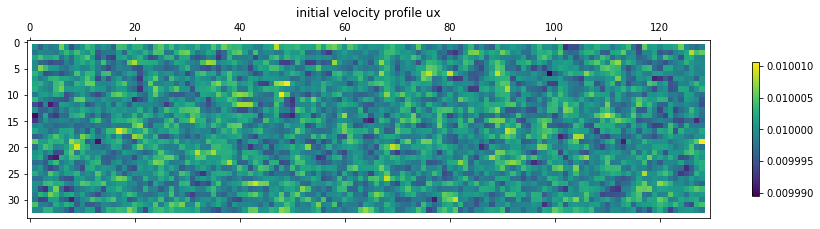

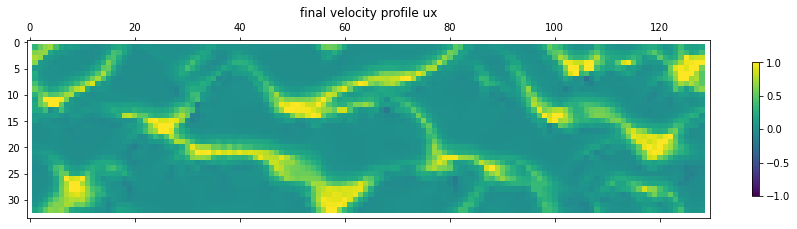

'\nTime series\n'

In [51]:
initial_ux_plot = plt.matshow(ux_history[3,:,:])
plt.colorbar(initial_ux_plot, shrink=0.6)
plt.title("initial velocity profile ux")
plt.show()
final_ux_plot = plt.matshow(ux_history[-1,:,:],vmin=-1,vmax=1)
plt.colorbar(final_ux_plot, shrink=0.6)
plt.title("final velocity profile ux")
plt.show()

"""
Time series
"""
# numerical_contourplot = []
# for i in range(time_steps):
#     numerical_contourplot.append( plt.matshow(ux_history[i,:,:],vmin=-1,vmax=1) )
#     plt.colorbar(numerical_contourplot[i], shrink=0.6)
#     plt.title("time step ="+str(i))
# plt.xlabel("x")
# plt.ylabel("y")
# plt.xlim(1,Nx)
# plt.ylim(1,Ny)

## Animation

In [52]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

image = ax.matshow(ux_history[0,:,:])
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(ux_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save("animation_ux.mp4")


<IPython.core.display.Javascript object>

In [53]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

image = ax.matshow(uy_history[0,:,:])
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(uy_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save("animation_uy.mp4")


<IPython.core.display.Javascript object>

In [54]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

image = ax.matshow(rho_history[0,:,:])
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(rho_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save("animation_rho.mp4")


<IPython.core.display.Javascript object>